## Introduction

This notebook will be where I find the best parameters on the models that performed best for Model1 (using T1, T2). I will do the final testing here as well.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import utils as F
from Models import LinearRegressor, LogisticRegressor, SVR_manual

from utils import cross_validation
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import BaggingClassifier, BaggingRegressor, RandomForestClassifier, RandomForestRegressor,StackingRegressor, GradientBoostingRegressor
from sklearn.metrics import accuracy_score, mean_absolute_error,mean_squared_error,confusion_matrix, make_scorer
from sklearn.tree import DecisionTreeRegressor, export_graphviz, DecisionTreeClassifier
from utils import manual_bagging, evaluate_regression_metrics, evaluate_classification_metrics, manual_Random_Forest
from sklearn.decomposition import KernelPCA, PCA
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import LinearRegression, LogisticRegression, RidgeCV, LassoCV, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import Isomap
from sklearn.datasets import make_regression
from sklearn.svm import SVR, SVC
from sklearn.neighbors import KNeighborsRegressor

import configparser
config = configparser.ConfigParser()
config.read('configuration.ini')

['configuration.ini']

In [3]:
data = pd.read_csv(config['created_files']['train'],sep = ',')
X_train_p = data.drop(columns=['T3']).reset_index(drop=True)
y_train_p = data['T3'].reset_index(drop=True)

X_train, X_test, y_train_unstd, y_test_unstd = train_test_split(X_train_p,y_train_p,test_size=0.2)

X_train, X_test, y_train,y_test,scaler_y = F.standarize_numerical_variables(X_train, X_test, y_train_unstd, y_test_unstd,1)

data = pd.read_csv(config['created_files']['test'],sep = ',')
X_test_final = data.drop(columns=['T3']).reset_index(drop=True)
y_test_final = data['T3'].reset_index(drop=True)

print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)

(628, 43)
(628,)
(157, 43)
(157,)


#### 1. Linear Regression

We saw in the other notebook that the linear regressor on itself has good performance. I tried to manually add relations between variables as well as doing an ensemble of linear regressors and using clustering information but none of them improved permormance, so using occam's razor I will discard them. 

There are no parameters to fit in linear regression, however, I will try to fit the stack since it had good permormance but seemed to be overfitted. I will try to search for the best parameters and try not to overfit using Grid search.

In [24]:
base_models = [
    ('lasso', LassoCV(cv=5)),
    ('RF', RandomForestRegressor(random_state=42)),
]
base_models1 = [
    ('RF', RandomForestRegressor(random_state=42)),
    ('svm', SVR(C=1.0, epsilon=0.2))
]

base_models2 = [
    ('gbr', GradientBoostingRegressor(random_state=42)),
    ('svr', SVR(C=1.0, epsilon=0.2)),
    ('ridge', RidgeCV(alphas=[0.1, 1.0, 10.0]))
]
base_models_3 = [
    ('rf', RandomForestRegressor(random_state=42)),
    ('knn', KNeighborsRegressor(n_neighbors=5))
]

pipe = Pipeline([
    ('stack', StackingRegressor(estimators=base_models, final_estimator=LinearRegression(),cv=5,passthrough=True,n_jobs=-1)),
])

param_grid = {
    'stack__final_estimator': [LinearRegression(), LassoCV()],
    'stack__estimators': [base_models,base_models1,base_models2,base_models_3]
}
grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search.fit(X_train, y_train_unstd)

y_pred = grid_search.predict(X_test)
y_pred_t = grid_search.predict(X_train)


print("Best parameters found:", grid_search.best_params_)
print("Best score (CV):", grid_search.best_score_)

results = evaluate_regression_metrics(y_test_unstd, y_train_unstd, y_pred, y_pred_t)
print(results)


Best parameters found: {'stack__estimators': [('lasso', LassoCV(cv=5)), ('RF', RandomForestRegressor(random_state=42))], 'stack__final_estimator': LassoCV()}
Best score (CV): 0.8666013219792573
{'Mean Absolute Error:': 0.9460654597793123, 'Mean Squared Error:': 3.4293955034858232, 'R² Score Test:': 0.8006434371835713, 'R² Score Train:': 0.9515834162885469}


I didn't find a better model. This idea overfits the data and has worse permormance than the linear regressor so it is finally discarded.

#### 2. Random Forest

Optimal value of k manual: 6 with a score of 0.8290093103574778
Optimal value of k sklearn: 50 with a score of 0.8159032262629121


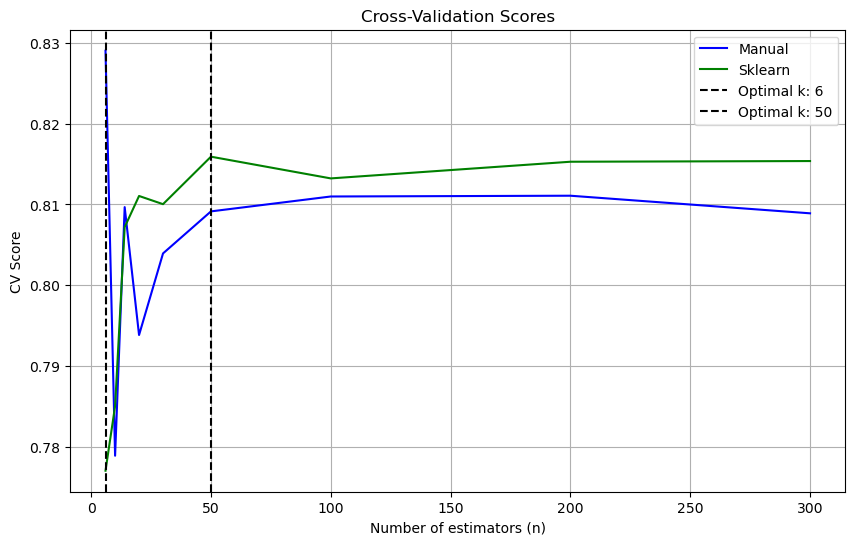

In [41]:
max_samples = 0.8
tipo = 'reg'
max_features = 0.8
manual = []
sklearnn = []
n_est = [6,10,14,20,30,50,100,200,300]

for n_estimators in n_est:
    #print(n_estimators)

    pred, score = manual_Random_Forest(X_train, y_train_unstd,X_test, y_test_unstd,n_estimators,max_samples,max_features,tipo)
    #print(f'Score Manual implementation: {score}')
    manual.append(score['R² Score Test:'])

    rf = RandomForestRegressor(random_state=0,n_estimators=n_estimators,max_features=max_features) 
    rf.fit(X_train, y_train_unstd)
    rf_pred = rf.predict(X_test)
    rf_pred_train = rf.predict(X_train)
    score = evaluate_regression_metrics(y_test_unstd,y_train_unstd,rf_pred,rf_pred_train)
    #print(f'Score Sklearn implementation: {score}')
    sklearnn.append(score['R² Score Test:'])

highest_score_manual = np.argmax(manual)
optimal_k_manual = n_est[highest_score_manual]

highest_score_sk = np.argmax(sklearnn)
optimal_k_sk = n_est[highest_score_sk]

print(f"Optimal value of k manual: {optimal_k_manual} with a score of {manual[highest_score_manual]}")
print(f"Optimal value of k sklearn: {optimal_k_sk} with a score of {sklearnn[highest_score_sk]}")

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(n_est,manual,'b',label= 'Manual')
plt.plot(n_est,sklearnn,'g',label='Sklearn')
plt.axvline(x=optimal_k_manual, linestyle='--', color='k', label=f'Optimal k: {optimal_k_manual}')
plt.axvline(x=optimal_k_sk, linestyle='--', color='k', label=f'Optimal k: {optimal_k_sk}')

plt.title('Cross-Validation Scores')
plt.xlabel('Number of estimators (n)')
plt.ylabel('CV Score')
plt.legend()
plt.grid(True)
plt.show()
    

In [39]:
mRF = RandomForestRegressor(n_estimators=50)
mRF.fit(X_train,y_train)
y_pred = mRF.predict(X_test)
y_pred_train = mRF.predict(X_train)

print('Internal score: ',mRF.score(X_test,y_test))
print(evaluate_regression_metrics(y_test,y_train,y_pred,y_pred_train))


Internal score:  0.8022778982123484
{'Mean Absolute Error:': 0.25401241019108906, 'Mean Squared Error:': 0.22655937175929958, 'R² Score Test:': 0.8022778982123484, 'R² Score Train:': 0.9788454534092421}


<Axes: >

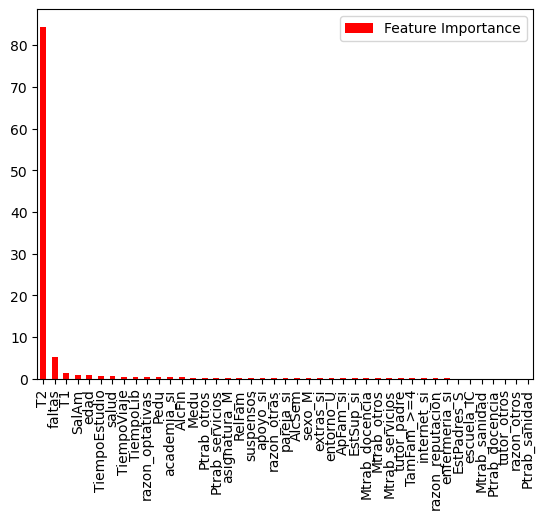

In [40]:
rf_featureImportance= pd.DataFrame({'Feature Importance':mRF.feature_importances_*100}, index= X_train.columns)
rf_featureImportance.sort_values('Feature Importance', ascending=False).plot(kind='bar', color='red')

This model shows overfitting, but the worse thing is its variance. Each time you run the code you get very different results, even if they have a score over 0.81 normally. I will discard Random Forest as well due to its lack of consistency. Bagging showed similar behaviour.

But it is interesting to see the most important variables. We see the most important ones match the ones we got with PCA.

#### 3. SVR